D:\anaconda1\envs\tensprflow\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda1\envs\tensprflow\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


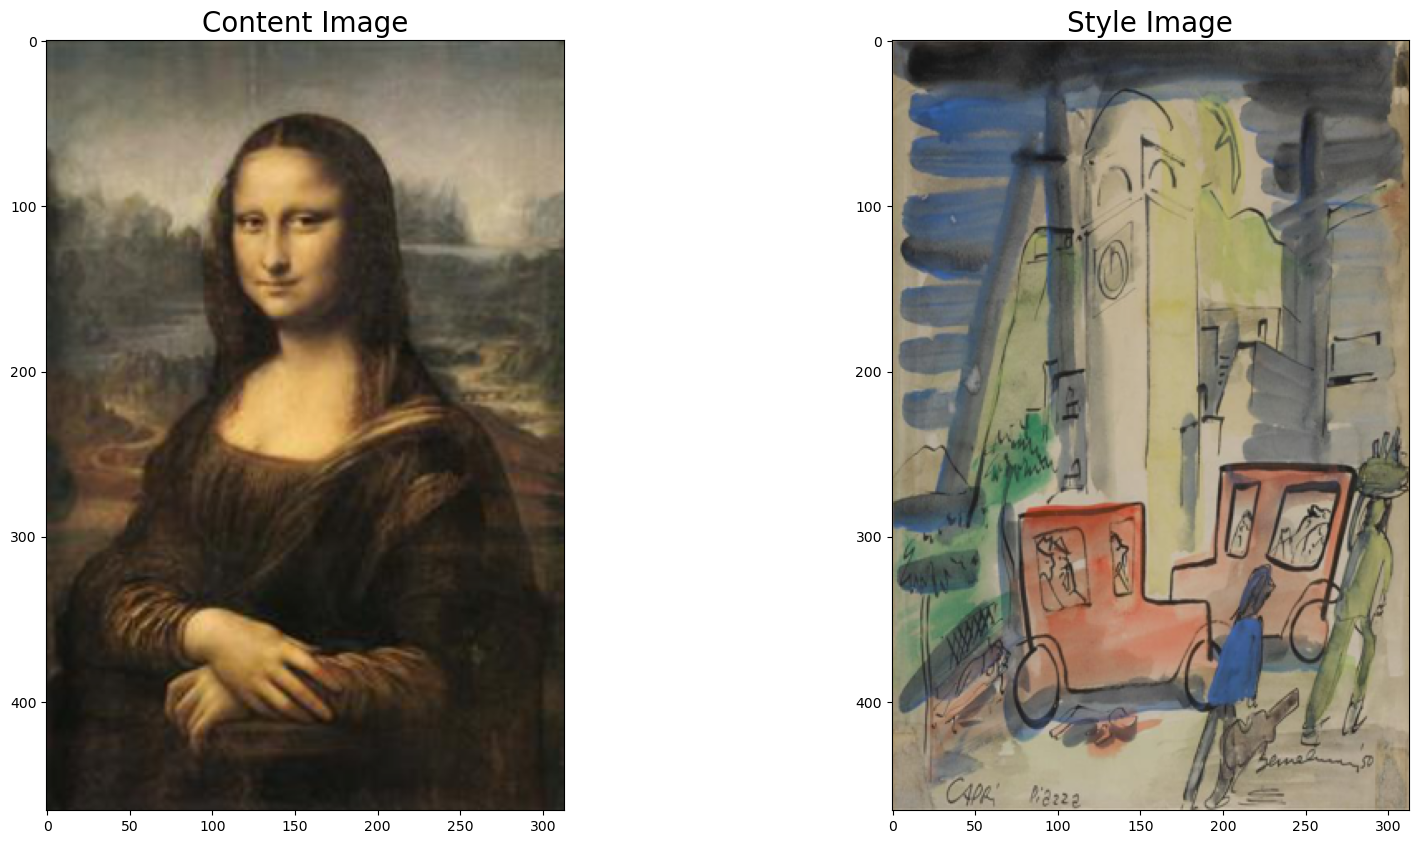

In [17]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-2]))  # Remove the last two layers

# Freeze all ResNet parameters since we're only optimizing the target image
for param in resnet.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Define the load_image function
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # Large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # Discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    
    return image


# Load content and style images
content = load_image("/content/train.jpg")
style = load_image("/content/style.jpg", shape=content.size()[2:])

# Display the content and style images
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# Content and style images side-by-side
ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize=20)
ax2.imshow(im_convert(style))
ax2.set_title("Style Image", fontsize=20)
plt.show()

# Define get_features function for ResNet-50
def get_features_resnet(image, model):
    """ Run an image forward through a ResNet-50 model and get the features for 
        a set of layers. """
    
    layers = {'layer1': 5, 'layer2': 6, 'layer3': 7, 'layer4': 8}  # Indices of the desired layers
    features = {}
    x = image
    for i, (name, layer) in enumerate(model._modules.items()):
        x = layer(x)
        if i in layers.values():
            features[list(layers.keys())[list(layers.values()).index(i)]] = x
            
    return features

# Define gram_matrix function
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

# Get content and style features
content_features = get_features_resnet(content, resnet)
style_features = get_features_resnet(style, resnet)

# Calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a third "target" image and prep it for change
# It is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

# Set content and style weights
content_weight = 1  # alpha
style_weight = 1e9  # beta

# Calculate content loss
content_loss = torch.mean((get_features_resnet(target, resnet)['layer3'] - content_features['layer3'])**2)


Step [0/100], Total Loss: 103377.328125
Step [50/100], Total Loss: 15427.677734375


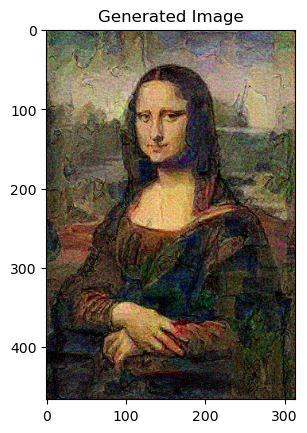

In [18]:
# Define the optimizer
optimizer = optim.LBFGS([target])

# Number of optimization steps
steps = 100

for step in range(steps):
    # Closure to recompute the loss and apply gradients
    def closure():
        optimizer.zero_grad()
        target_features = get_features_resnet(target, resnet)

        # Calculate content loss
        loss_content = torch.mean((target_features['layer3'] - content_features['layer3'])**2)

        # Calculate style loss
        loss_style = 0
        for layer in style_grams:
            target_gram = gram_matrix(target_features[layer])
            loss_style += torch.mean((target_gram - style_grams[layer])**2) / (target_gram.size(0) * target_gram.size(1))

        # Calculate total loss
        loss = content_weight * loss_content + style_weight * loss_style
        loss.backward()

        return loss

    # Optimize the target image
    optimizer.step(closure)

    # Print the loss every 50 steps
    if step % 50 == 0:
        print(f"Step [{step}/{steps}], Total Loss: {closure().item()}")

# Convert the target image tensor back to a PIL image
generated_image = im_convert(target.detach())

# Display the generated image
plt.imshow(generated_image)
plt.title("Generated Image")
plt.show()
